In [1]:
# import
import warnings
import os
import sys
import cv2
import pickle
import math
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import pyautogui as pg

from time import time, sleep
from tqdm import tqdm
from glob import glob
from pprint import pprint
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from threading import Thread
from matplotlib import pyplot as plt
from line_profiler import LineProfiler


class Samples_container:
    imgs_real_part = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/part/*.jpg")
    imgs_color_black = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/color/black/*.jpg")
    imgs_color_white = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/color/white/*.jpg")
    imgs_color_green = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/color/green/*.jpg")
    imgs_color_red = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/color/red/*.jpg")
    imgs_entire = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/entire/*.jpg")
    imgs_part = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/generated/picture/*.png")
    videos_num = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/generated/video/number/*.mp4")
    videos = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/generated/video/*.mp4")


In [2]:
# initial settings

print("OpenCV", cv2.__version__)
print("numpy", np.__version__)
print("pandas", pd.__version__)
print("Pyautogui", pg.__version__)
print("Scikit-learn", sklearn.__version__)

warnings.simplefilter('ignore')  # すべての警告を非表示にする


def SaveInstances(instance, path):
    '''
    PickleモジュールのWrapper
    instanceのオブジェクトをpathで指定したファイルパスに保存する。
    '''
    with open(path, mode='wb') as file:
        pickle.dump(instance, file, protocol=2)


def LoadInstances(path):
    '''
    PickleモジュールのWrapper
    pathに保存されているpickle形式のファイルをオブジェクトとして読み込む。
    '''
    with open(path, 'rb') as ins:
        return pickle.load(ins)


samples = Samples_container()


OpenCV 4.5.4
numpy 1.20.1
pandas 1.2.4
Pyautogui 0.9.53
Scikit-learn 0.24.1


In [3]:
# カラーパレットを用意する
from matplotlib.colors import ListedColormap
colors = ["white", "black", "green", "red"]
cmap = ListedColormap(colors, name="custom")

col_model = LoadInstances("./ColorReco2.pickle")


In [4]:
allOf_samples = np.empty_like([range(6)])

for path in samples.videos_num:
    result = int(os.path.basename(path)[:-4])
    video = cv2.VideoCapture(path)
    frame_count = math.floor(video.get(cv2.CAP_PROP_FRAME_COUNT))
    for _ in tqdm(range(frame_count)):
        ret, frame = video.read()
        # 処理

        frame = cv2.resize(frame, (64, 36))
        height, width = frame.shape[:2]

        # 色を識別する
        recognized_frame = np.flipud(np.reshape(
            col_model.predict(
                np.reshape(frame, (-1, 3))
            ), np.shape(frame)[:2]
        ))

        # 画像縦列における黒の出現割合
        black_distribution_weighted_bottom = np.sum(
            np.array(np.where(recognized_frame == 1, 1, 0)) * np.reshape(np.arange(len(recognized_frame), 0, -1), (-1, 1)), axis=0
        )
        black_distribution_weighted_top = np.sum(
            np.array(np.where(recognized_frame == 1, 1, 0)) * np.reshape(np.arange(0, len(recognized_frame), 1), (-1, 1)), axis=0
        )

        # 画像縦列における黒の出現位置の中心インデックス
        black_center_position_weighted_bottom = np.round(
            (np.sum(black_distribution_weighted_bottom * np.arange(0, len(black_distribution_weighted_bottom), 1))
             ) / np.sum(black_distribution_weighted_bottom) / width, 2)
        black_center_position_weighted_top = np.round(
            (np.sum(black_distribution_weighted_top * np.arange(0, len(black_distribution_weighted_top), 1))
             ) / np.sum(black_distribution_weighted_top) / width, 2)

        # 画像全体における赤の出現インデックスを抽出
        temp_red_appeared = np.where(recognized_frame == 3)
        red_appeared = np.hstack((np.reshape(temp_red_appeared[0], (-1, 1)), np.reshape(temp_red_appeared[1], (-1, 1))))  # ["height", "width"]
        occupy_red_appeared = np.round(len(red_appeared) / (height * width), 2)

        is_green_found = len(np.where(recognized_frame == 2)[0]) != 0
        if is_green_found:
            # 画像全体における緑の出現インデックスを抽出
            OFFSET_CHECK_EXIST_BLACK = 7
            temp_recognized_frame = np.copy(recognized_frame)
            temp_recognized_frame[OFFSET_CHECK_EXIST_BLACK * -1:, :] = 0
            temp_green_appeared = np.where(temp_recognized_frame == 2)
            green_appeared = np.hstack((np.reshape(temp_green_appeared[0], (-1, 1)),
                                       np.reshape(temp_green_appeared[1], (-1, 1))))  # ["height", "width"]
            occupy_green_appeared = np.round(len(green_appeared) / (height * width), 2)

            # 緑の上方に出現する黒の総量を取得する
            green_appeared += [OFFSET_CHECK_EXIST_BLACK, 0]
            percent_black_topOf_green = np.round(np.sum(np.where(recognized_frame == 1, 1, 0)[
                green_appeared[:, 0], green_appeared[:, 1]]) / len(green_appeared), 2)
        else:
            percent_black_topOf_green = 0.0
            occupy_green_appeared = 0.0
        # print("Timer: {:,.3f} sec\nExpected-speed: {:,.1f} frame/sec\nFrame: {:,}px {:,}px".format(timer, 1 / timer, height, width))

        # 表示用に調整する
        recognized_frame[0][0] = 0  # black
        recognized_frame[0][1] = 1  # green
        recognized_frame[0][2] = 2  # white
        recognized_frame[0][3] = 3  # red

        # 表示
        res = [[
            black_center_position_weighted_bottom,
            black_center_position_weighted_top,
            occupy_green_appeared * 5,
            occupy_red_appeared * 5,
            percent_black_topOf_green * 5,
            result
        ]]
        # 処理
        allOf_samples = np.append(allOf_samples, res, axis=0).astype(np.float32)

allOf_samples = np.nan_to_num(allOf_samples[1:, :])
allOf_samples


100%|██████████| 4454/4454 [00:05<00:00, 756.29it/s]


array([[   0.24,    0.14,    0.  ,    0.  ,    0.  , -100.  ],
       [   0.32,    0.18,    0.  ,    0.  ,    0.  , -100.  ],
       [   0.26,    0.15,    0.  ,    0.  ,    0.  , -100.  ],
       ...,
       [   0.54,    0.69,    0.  ,    0.  ,    0.  ,   50.  ],
       [   0.63,    0.75,    0.  ,    0.  ,    0.  ,   50.  ],
       [   0.58,    0.71,    0.  ,    0.  ,    0.  ,   50.  ]],
      dtype=float32)

LinearRegression()


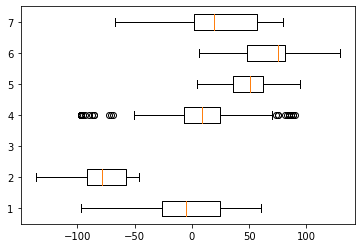

SGDRegressor()


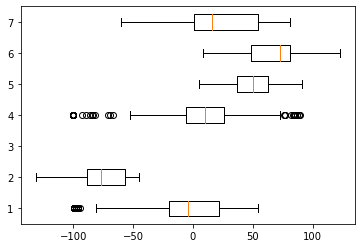

KernelRidge()


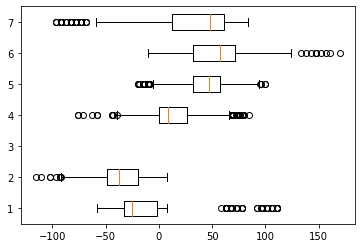

ElasticNet()


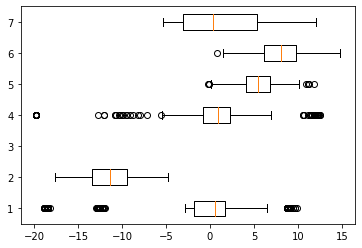

BayesianRidge()


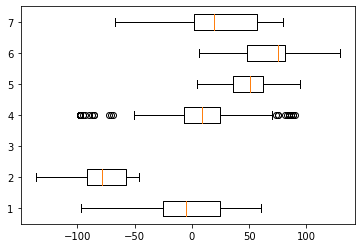

GradientBoostingRegressor()


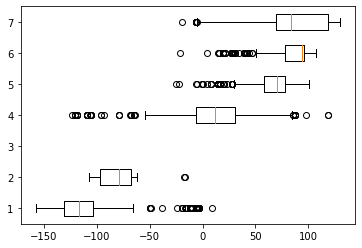

SVR()


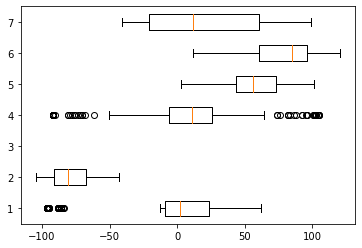

MLPRegressor()


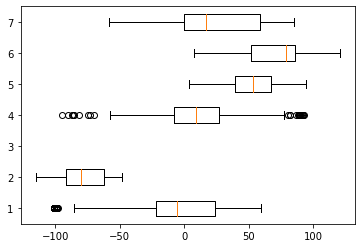

In [5]:
from sklearn.linear_model import LinearRegression  # 線形回帰
from sklearn.linear_model import SGDRegressor  # 確率的勾配降下回帰
from sklearn.kernel_ridge import KernelRidge  # カーネルリッジ回帰
from sklearn.linear_model import ElasticNet  # エラスティックネット回帰
from sklearn.linear_model import BayesianRidge  # ベイジアンリッジ回帰
from sklearn.ensemble import GradientBoostingRegressor  # 勾配ブースティング回帰
from sklearn.svm import SVR  # サポートベクターマシン
from sklearn.neural_network import MLPRegressor

X_train, X_test, y_train, y_test = train_test_split(
    allOf_samples[:, :-1],
    allOf_samples[:, -1],
    test_size=0.1,  # テストに使う割合
)
models = [
    LinearRegression(),
    SGDRegressor(),
    KernelRidge(),
    ElasticNet(),
    BayesianRidge(),
    GradientBoostingRegressor(),
    SVR(),
    MLPRegressor(),
]

for model_base in models:
    print(model_base)
    direct_model = model_base.fit(X_train, y_train)
    plt.boxplot([
        direct_model.predict(X_test)[y_test == -150],
        direct_model.predict(X_test)[y_test == -100],
        direct_model.predict(X_test)[y_test == -500],
        direct_model.predict(X_test)[y_test == 0],
        direct_model.predict(X_test)[y_test == 50],
        direct_model.predict(X_test)[y_test == 100],
        direct_model.predict(X_test)[y_test == 150],
    ], vert=False
    )
    plt.show()


In [6]:
direct_model = LinearRegression().fit(X_train, y_train)


[0.48, 0.5, 0.25, 0.0, 3.95] [0.32871216]


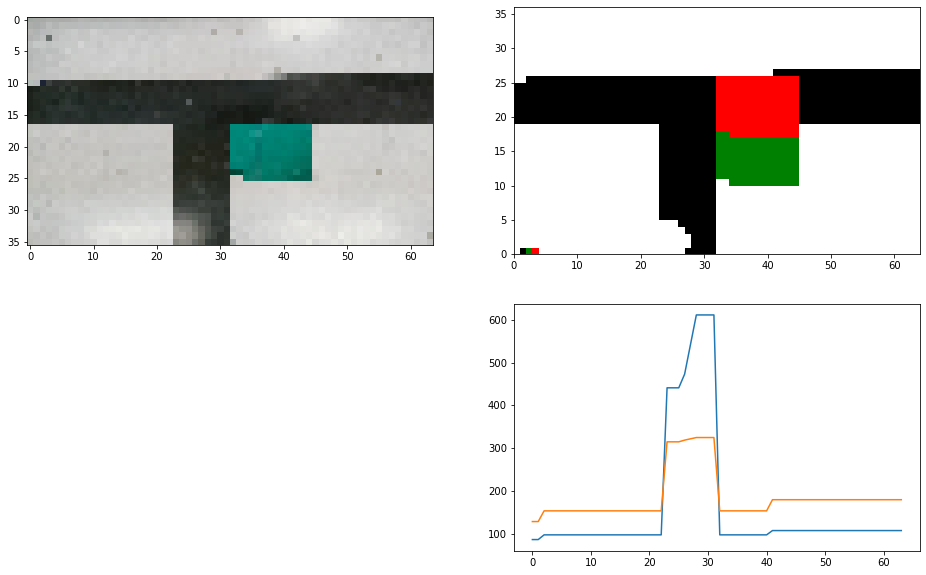

[0.44, 0.47, 0.0, 0.0, 0.0] [-3.44365936]


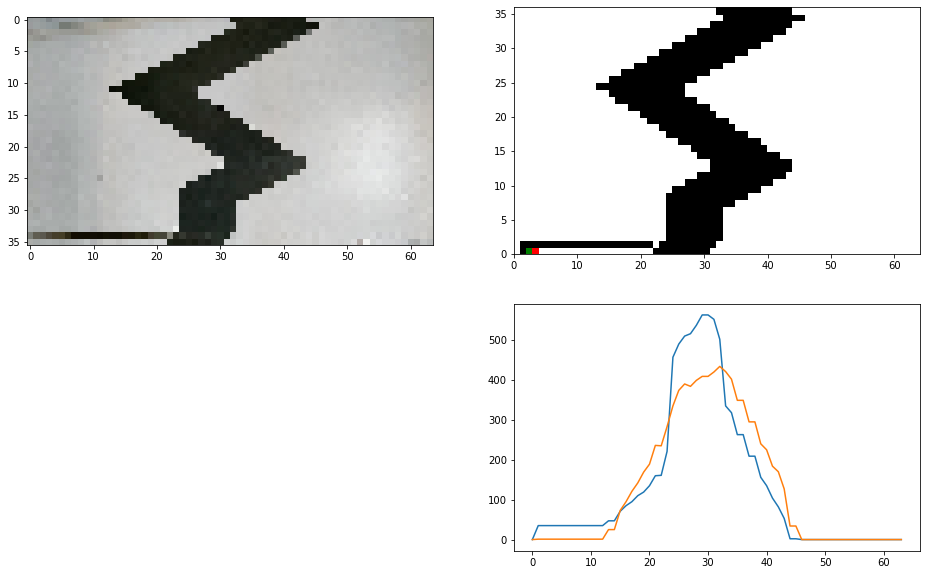

[0.54, 0.53, 0.0, 0.0, 0.0] [0.37330841]


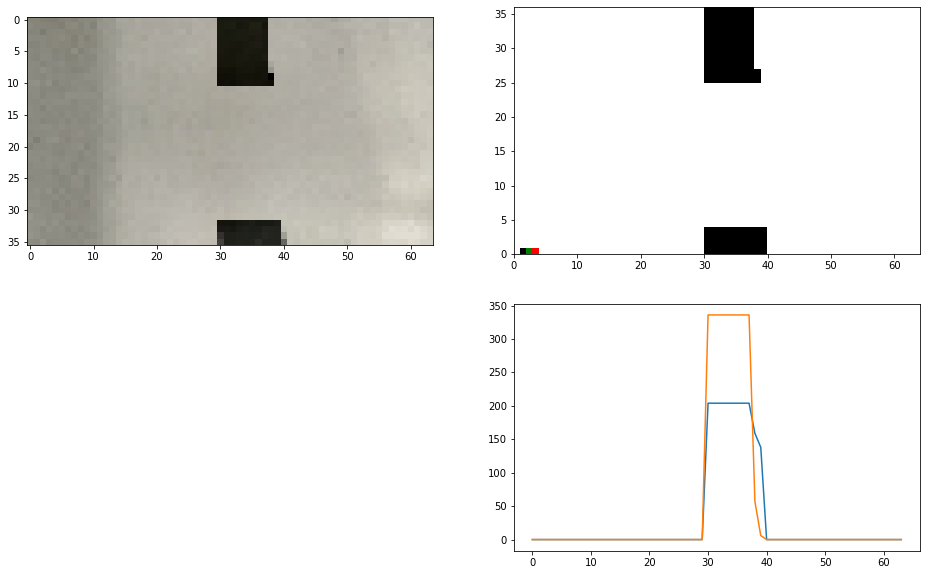

[0.51, 0.65, 0.0, 0.0, 0.0] [50.87665955]


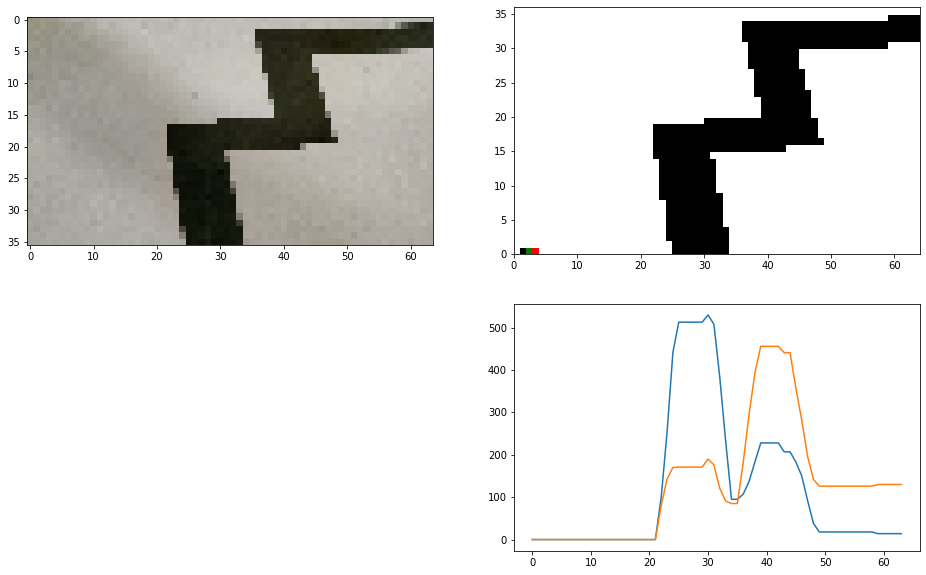

[0.49, 0.63, 0.0, 0.0, 0.0] [47.11915344]


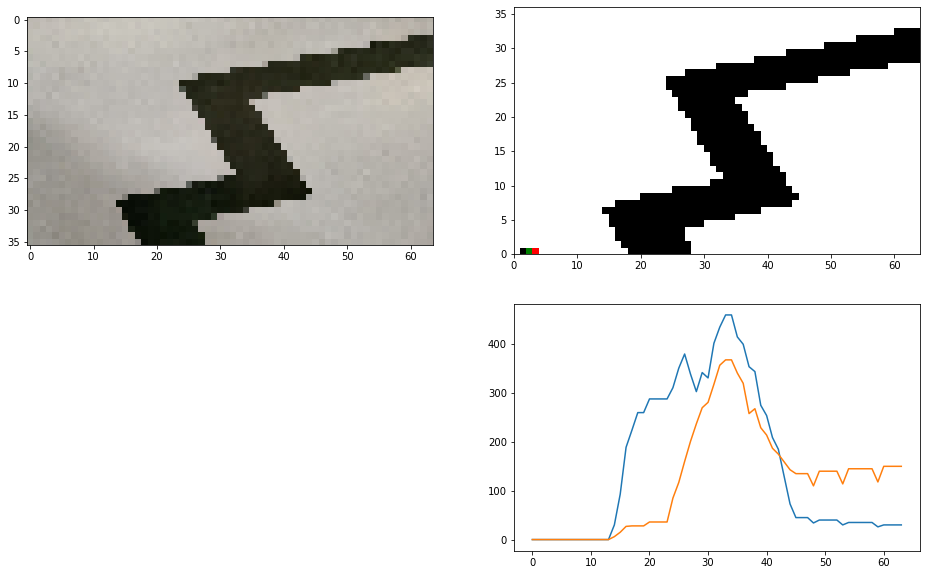

In [7]:
for path in samples.imgs_real_part:
    # 写真を読み込む
    frame = cv2.imread(path)

    frame = cv2.resize(frame, (64, 36))
    height, width = frame.shape[:2]

    # 色を識別する
    recognized_frame = np.flipud(np.reshape(
        col_model.predict(
            np.reshape(frame, (-1, 3))
        ), np.shape(frame)[:2]
    ))

    # 画像縦列における黒の出現割合
    black_distribution_weighted_bottom = np.sum(
        np.array(np.where(recognized_frame == 1, 1, 0)) * np.reshape(np.arange(len(recognized_frame), 0, -1), (-1, 1)), axis=0
    )
    black_distribution_weighted_top = np.sum(
        np.array(np.where(recognized_frame == 1, 1, 0)) * np.reshape(np.arange(0, len(recognized_frame), 1), (-1, 1)), axis=0
    )

    # 画像縦列における黒の出現位置の中心インデックス
    black_center_position_weighted_bottom = np.round(
        (np.sum(black_distribution_weighted_bottom * np.arange(0, len(black_distribution_weighted_bottom), 1))
         ) / np.sum(black_distribution_weighted_bottom) / width, 2)
    black_center_position_weighted_top = np.round(
        (np.sum(black_distribution_weighted_top * np.arange(0, len(black_distribution_weighted_top), 1))
         ) / np.sum(black_distribution_weighted_top) / width, 2)

    # 画像全体における赤の出現インデックスを抽出
    temp_red_appeared = np.where(recognized_frame == 3)
    red_appeared = np.hstack((np.reshape(temp_red_appeared[0], (-1, 1)), np.reshape(temp_red_appeared[1], (-1, 1))))  # ["height", "width"]
    occupy_red_appeared = np.round(len(red_appeared) / (height * width), 2)

    is_green_found = len(np.where(recognized_frame == 2)[0]) != 0
    if is_green_found:
        # 画像全体における緑の出現インデックスを抽出
        OFFSET_CHECK_EXIST_BLACK = 7
        temp_recognized_frame = np.copy(recognized_frame)
        temp_recognized_frame[OFFSET_CHECK_EXIST_BLACK * -1:, :] = 0
        temp_green_appeared = np.where(temp_recognized_frame == 2)
        green_appeared = np.hstack((np.reshape(temp_green_appeared[0], (-1, 1)), np.reshape(temp_green_appeared[1], (-1, 1))))  # ["height", "width"]
        occupy_green_appeared = np.round(len(green_appeared) / (height * width), 2)

        # 緑の上方に出現する黒の総量を取得する
        green_appeared += [OFFSET_CHECK_EXIST_BLACK, 0]
        percent_black_topOf_green = np.round(np.sum(np.where(recognized_frame == 1, 1, 0)[
            green_appeared[:, 0], green_appeared[:, 1]]) / len(green_appeared), 2)
    else:
        percent_black_topOf_green = 0.0
        occupy_green_appeared = 0.0
    # print("Timer: {:,.3f} sec\nExpected-speed: {:,.1f} frame/sec\nFrame: {:,}px {:,}px".format(timer, 1 / timer, height, width))

    # 表示用に調整する
    recognized_frame[0][0] = 0  # black
    recognized_frame[0][1] = 1  # green
    recognized_frame[0][2] = 2  # white
    recognized_frame[0][3] = 3  # red

    # 表示
    features = [
        black_center_position_weighted_bottom,
        black_center_position_weighted_top,
        occupy_green_appeared * 5,
        occupy_red_appeared * 5,
        percent_black_topOf_green * 5,
    ]

    print(features, direct_model.predict([features]))
    if is_green_found:
        recognized_frame[green_appeared[:, 0], green_appeared[:, 1]] = 3
    plt.figure(figsize=(16, 10))
    plt.subplot(221)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # -> 注意
    plt.subplot(222)
    plt.pcolormesh(recognized_frame, cmap=cmap)
    plt.subplot(224)
    plt.plot(black_distribution_weighted_bottom)
    plt.plot(black_distribution_weighted_top)
    plt.show()
